In [1]:
from predict import perform_inference
from rfw_loader import create_dataloaders
from train import train, write_model, save_model

import torch

In [2]:
EPOCHS = 5
LEARNING_RATE = 0.01
RATIO = 0.8
BATCH_SIZE = 32
DEVICE = 1

In [3]:
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

# Train Models on Compressed images

In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F


class MultiHeadResNet(nn.Module):
    def __init__(self, output_dims):
        super(MultiHeadResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.heads = nn.ModuleDict()
        for head, num_classes in output_dims.items():
            self.heads[head] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.resnet(x).squeeze()
        outputs = {}
        for head, head_module in self.heads.items():
            output_logits = head_module(features)
            outputs[head] = F.softmax(output_logits, dim=1)
        return outputs

In [5]:
def train_numerical_rfw(model, num_epochs, lr, train_loader, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for inputs, targets, races in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = 0
                for i, head in enumerate(outputs):
                    loss += criterion(outputs[head], targets[:, i].to(torch.int64))
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                avg_loss = running_loss / ((pbar.n + 1) * len(inputs))  # Compute average loss
                pbar.set_postfix(loss=avg_loss)
                pbar.update(1)
    return model

In [13]:
from tqdm import tqdm
import numpy as np

def save_race_based_predictions(
        model, 
        model_name, 
        dataloader, 
        device, 
        prediction_save_dir,
        save_labels=False
    ):
    all_predictions = {'Indian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                       'Caucasian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                       'Asian': {head: torch.tensor([]) for head in model.heads.keys()},  
                       'African': {head: torch.tensor([]) for head in model.heads.keys()}}
    all_labels = {'Indian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                  'Caucasian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                  'Asian': {head: torch.tensor([]) for head in model.heads.keys()}, 
                  'African': {head: torch.tensor([]) for head in model.heads.keys()}}
    
    print(f'prediction_save_dir: {prediction_save_dir}')
    dataloader = tqdm(dataloader, desc="Getting Predictions", unit="batch")
    model.eval()
    with torch.no_grad():
        for _, data in enumerate(dataloader):
            inputs, labels, race = data
            race = np.array(race)

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            for i, (head, predictions) in enumerate(outputs.items()):
                head_preds = predictions.argmax(dim=1).cpu()

                for race_label in all_labels:
                    race_indices = np.array((race == race_label).nonzero()[0])
                    race_predictions = head_preds[race_indices]
                    race_labels = labels[:, i][race_indices]
                
                    all_predictions[race_label][head] = torch.cat((all_predictions[race_label][head], race_predictions.to('cpu')), dim=0)
                    all_labels[race_label][head] = torch.cat((all_labels[race_label][head], race_labels.to('cpu')), dim=0)

    for race_label in all_labels:
        for category in all_labels[race_label]:
            torch.save(all_predictions[race_label][category], f'{prediction_save_dir}/{model_name}_{race_label}_{category}_predictions.pt')
            if save_labels:
                torch.save(all_labels[race_label][category], f'{prediction_save_dir}/{model_name}_{race_label}_{category}_labels.pt')

    return all_predictions, all_labels


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_classification_report(races, categories, pred_dir, model_name):
    results = {'acc': {}, 'f1': {}}
    for category in categories:
        results['acc'][category] = {}
        results['f1'][category] = {}
        for race in races:
            results['acc'][category][race] = {}
            results['f1'][category][race] = {}
            preds = torch.load(f'{pred_dir}/{model_name}_{race}_{category}_predictions.pt')
            labels = torch.load(f'{pred_dir}/{model_name}_{race}_{category}_labels.pt')
            acc = accuracy_score(labels, preds)
            f1 = f1_score(labels, preds, average='weighted')
            results['acc'][category][race] = acc
            results['f1'][category][race] = f1
    
    return results


In [21]:
ROOT='/media/global_data/fair_neural_compression_data/decoded_rfw'
PRED_SAVE_DIR = '../results/RFW/predictions/output model preds'
MODEL_NAME = 'RFW_resnet18'
lambda_value = 64
data_rates = [1, 3, 6, 9, 12]
trained_models = []
num_epochs = 5
lr = 0.01
output_dims = {
    'skin_type': 6,
    'eye_type': 2,
    'nose_type': 2,
    'lip_type': 2,
    'hair_type': 4,
    'hair_color': 5
}
races = ['Indian', 'Asian', 'African', 'Caucasian']
categories = list(output_dims.keys())

performance_metrics = []
for data_rate in data_rates:
    compressed_image_path = f'{ROOT}/progressive_64x64/qres17m/q_{lambda_value}/{data_rate}'
    RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
    train_loader, test_loader = create_dataloaders(
        compressed_image_path, 
        RFW_LABELS_DIR, 
        BATCH_SIZE, 
        RATIO
    )
    model = MultiHeadResNet(output_dims).to(device)
    trained_model = train_numerical_rfw(model, num_epochs, lr, train_loader, device)
    save_model(trained_model, '../models', f'{MODEL_NAME}_lambda={lambda_value}_datarate={data_rate}')
    trained_models.append(trained_model)
    preds, labels = save_race_based_predictions(
        model, 
        f'{MODEL_NAME}_lambda={lambda_value}_datarate={data_rate}', 
        test_loader, 
        device, 
        PRED_SAVE_DIR,
        save_labels=True
    )
    performance = get_classification_report(
        races,
        categories,
        PRED_SAVE_DIR,
        f'{MODEL_NAME}_lambda={lambda_value}_datarate={data_rate}'
    )
    print(f'performance for model with lambda={lambda_value} and data_rate={data_rate}')
    print(f'performance_metrics = {performance}')
    performance_metrics.append(performance)

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 5/5: 100%|██████████| 1016/1016 [00:49<00:00, 20.56it/s, loss=37.3]


Writing Model
Model Saved
prediction_save_dir: ../results/RFW/predictions/output model preds


Getting Predictions: 100%|██████████| 254/254 [00:10<00:00, 25.06batch/s]
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


performance for model with lambda=64 and data_rate=1
performance_metrics = {'acc': {'skin_type': {'Indian': 0.4119047619047619, 'Asian': 0.5457380457380457, 'African': 0.28327806726669824, 'Caucasian': 0.38852541519879213}, 'eye_type': {'Indian': 0.5442857142857143, 'Asian': 0.7744282744282744, 'African': 0.4419706300331596, 'Caucasian': 0.8495218922999497}, 'nose_type': {'Indian': 0.5290476190476191, 'Asian': 0.5452182952182952, 'African': 0.7252486972998579, 'Caucasian': 0.5691997986914947}, 'lip_type': {'Indian': 0.9604761904761905, 'Asian': 0.1340956340956341, 'African': 0.980104216011369, 'Caucasian': 0.9662808253648717}, 'hair_type': {'Indian': 0.5942857142857143, 'Asian': 0.7905405405405406, 'African': 0.3391757460918996, 'Caucasian': 0.6240563663814797}, 'hair_color': {'Indian': 0.6552380952380953, 'Asian': 0.7001039501039501, 'African': 0.945523448602558, 'Caucasian': 0.21640664318067437}}, 'f1': {'skin_type': {'Indian': 0.42258374109728714, 'Asian': 0.5257489165017111, 'Afric

Epoch 5/5: 100%|██████████| 1016/1016 [00:46<00:00, 21.68it/s, loss=37]  


Writing Model
Model Saved
prediction_save_dir: ../results/RFW/predictions/output model preds


Getting Predictions: 100%|██████████| 254/254 [00:10<00:00, 25.35batch/s]
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


performance for model with lambda=64 and data_rate=3
performance_metrics = {'acc': {'skin_type': {'Indian': 0.4142857142857143, 'Asian': 0.5410602910602911, 'African': 0.33633349123638084, 'Caucasian': 0.39406139909411175}, 'eye_type': {'Indian': 0.5419047619047619, 'Asian': 0.751039501039501, 'African': 0.567029843675983, 'Caucasian': 0.8142929038751887}, 'nose_type': {'Indian': 0.5023809523809524, 'Asian': 0.5519750519750519, 'African': 0.6802463287541449, 'Caucasian': 0.58379466532461}, 'lip_type': {'Indian': 0.871904761904762, 'Asian': 0.31496881496881496, 'African': 0.9673140691615348, 'Caucasian': 0.8711625566180171}, 'hair_type': {'Indian': 0.5747619047619048, 'Asian': 0.7707900207900208, 'African': 0.4315490288962577, 'Caucasian': 0.6024157020634122}, 'hair_color': {'Indian': 0.6552380952380953, 'Asian': 0.7001039501039501, 'African': 0.945523448602558, 'Caucasian': 0.21640664318067437}}, 'f1': {'skin_type': {'Indian': 0.4281536900197611, 'Asian': 0.5123567847327711, 'African':

Epoch 5/5: 100%|██████████| 1016/1016 [00:47<00:00, 21.38it/s, loss=34.2]


Writing Model
Model Saved
prediction_save_dir: ../results/RFW/predictions/output model preds


Getting Predictions: 100%|██████████| 254/254 [00:10<00:00, 24.95batch/s]
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


performance for model with lambda=64 and data_rate=6
performance_metrics = {'acc': {'skin_type': {'Indian': 0.659047619047619, 'Asian': 0.5540540540540541, 'African': 0.517764092846992, 'Caucasian': 0.2556618017111223}, 'eye_type': {'Indian': 0.5342857142857143, 'Asian': 0.7177754677754677, 'African': 0.7854097584083373, 'Caucasian': 0.7710115752390538}, 'nose_type': {'Indian': 0.6204761904761905, 'Asian': 0.6018711018711018, 'African': 0.8313595452392231, 'Caucasian': 0.579768495218923}, 'lip_type': {'Indian': 0.9571428571428572, 'Asian': 0.5545738045738046, 'African': 0.9876835622927522, 'Caucasian': 0.9194765978862607}, 'hair_type': {'Indian': 0.5876190476190476, 'Asian': 0.7978170478170478, 'African': 0.6925627664613927, 'Caucasian': 0.626572722697534}, 'hair_color': {'Indian': 0.6552380952380953, 'Asian': 0.7001039501039501, 'African': 0.945523448602558, 'Caucasian': 0.21640664318067437}}, 'f1': {'skin_type': {'Indian': 0.6245179625609122, 'Asian': 0.5456712571597521, 'African': 0

Epoch 5/5: 100%|██████████| 1016/1016 [00:48<00:00, 20.77it/s, loss=33.3]


Writing Model
Model Saved
prediction_save_dir: ../results/RFW/predictions/output model preds


Getting Predictions: 100%|██████████| 254/254 [00:10<00:00, 24.74batch/s]
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


performance for model with lambda=64 and data_rate=9
performance_metrics = {'acc': {'skin_type': {'Indian': 0.6628571428571428, 'Asian': 0.6143451143451143, 'African': 0.5291331122690668, 'Caucasian': 0.3598389531957725}, 'eye_type': {'Indian': 0.5833333333333334, 'Asian': 0.7422037422037422, 'African': 0.7891994315490289, 'Caucasian': 0.8122798188223452}, 'nose_type': {'Indian': 0.6457142857142857, 'Asian': 0.6278586278586279, 'African': 0.8356229275225012, 'Caucasian': 0.6054353296426774}, 'lip_type': {'Indian': 0.949047619047619, 'Asian': 0.8066528066528067, 'African': 0.9838938891520607, 'Caucasian': 0.8938097634625063}, 'hair_type': {'Indian': 0.5961904761904762, 'Asian': 0.8118503118503119, 'African': 0.7081951681667457, 'Caucasian': 0.6331152491192753}, 'hair_color': {'Indian': 0.6552380952380953, 'Asian': 0.7245322245322245, 'African': 0.9445760303173851, 'Caucasian': 0.3477604428787116}}, 'f1': {'skin_type': {'Indian': 0.6359933271588005, 'Asian': 0.5968224871725896, 'African'

Epoch 5/5: 100%|██████████| 1016/1016 [00:49<00:00, 20.60it/s, loss=33.4]


Writing Model
Model Saved
prediction_save_dir: ../results/RFW/predictions/output model preds


Getting Predictions: 100%|██████████| 254/254 [00:10<00:00, 24.84batch/s]


performance for model with lambda=64 and data_rate=12
performance_metrics = {'acc': {'skin_type': {'Indian': 0.6533333333333333, 'Asian': 0.6216216216216216, 'African': 0.5528185693983894, 'Caucasian': 0.35933568193256166}, 'eye_type': {'Indian': 0.6071428571428571, 'Asian': 0.7817047817047817, 'African': 0.7929891046897205, 'Caucasian': 0.8384499245093106}, 'nose_type': {'Indian': 0.6576190476190477, 'Asian': 0.617983367983368, 'African': 0.8356229275225012, 'Caucasian': 0.6049320583794665}, 'lip_type': {'Indian': 0.9285714285714286, 'Asian': 0.8643451143451143, 'African': 0.984367598294647, 'Caucasian': 0.8746854554604933}, 'hair_type': {'Indian': 0.590952380952381, 'Asian': 0.8118503118503119, 'African': 0.719090478446234, 'Caucasian': 0.6295923502767992}, 'hair_color': {'Indian': 0.6552380952380953, 'Asian': 0.7001039501039501, 'African': 0.945523448602558, 'Caucasian': 0.21640664318067437}}, 'f1': {'skin_type': {'Indian': 0.6321642392285258, 'Asian': 0.6043457819776044, 'African':

# Plot Results

In [24]:
import json

bpps = []
for data_rate in data_rates:
    json_path = f'{ROOT}/progressive_64x64/qres17m/q_{lambda_value}/{data_rate}/stats.json'
    with open(json_path, 'r') as json_file:
        data_dict = json.load(json_file)
        bpps.append(data_dict['results']['bpp'])

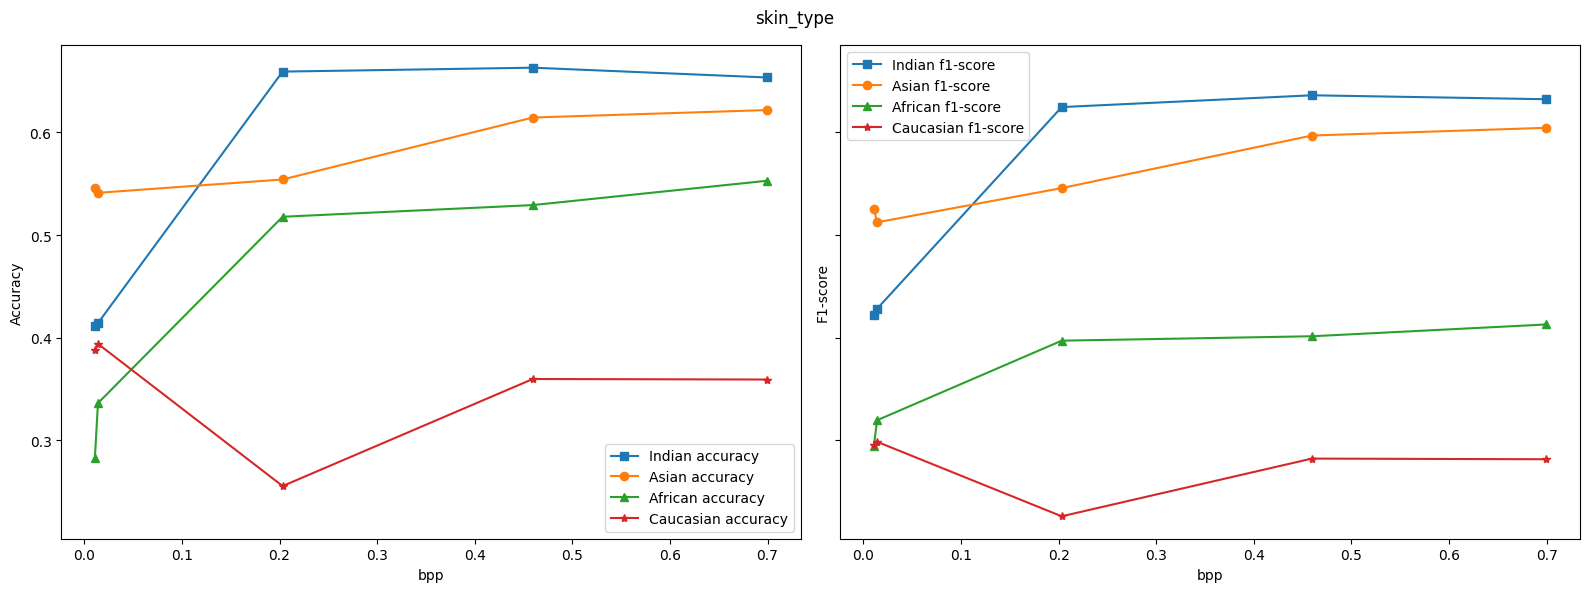

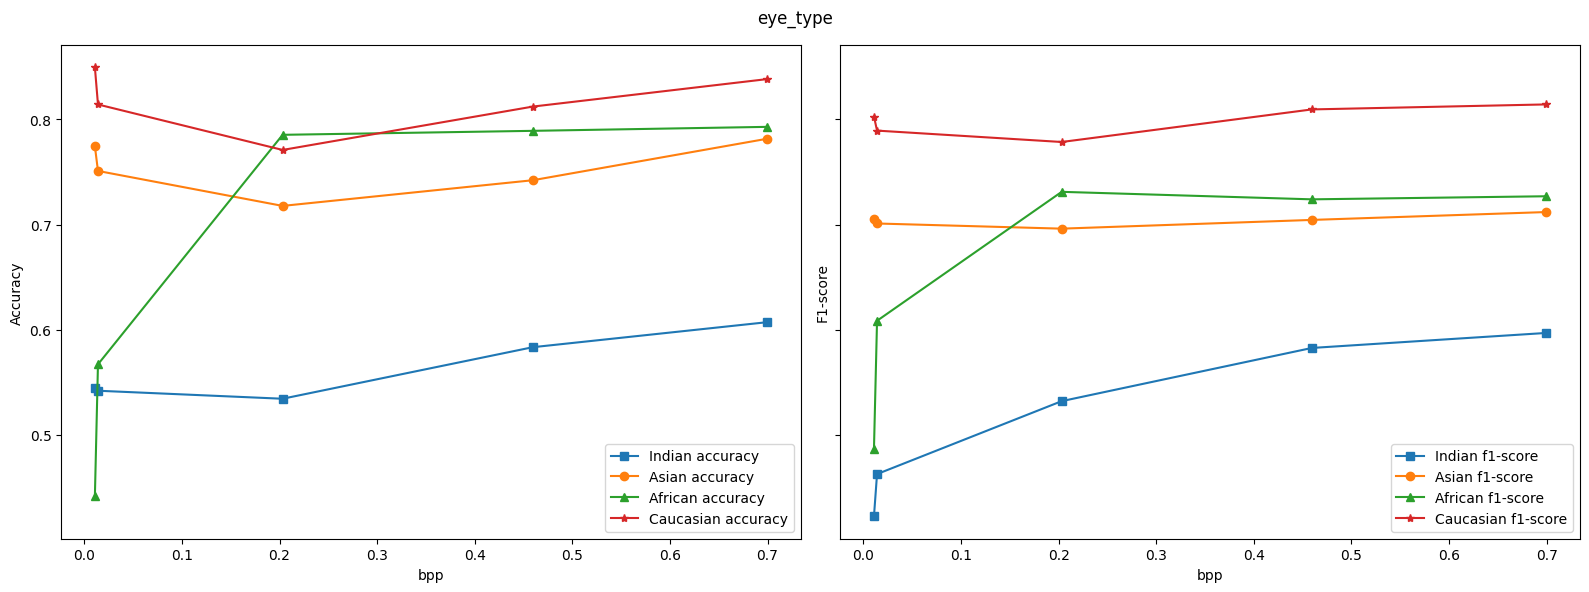

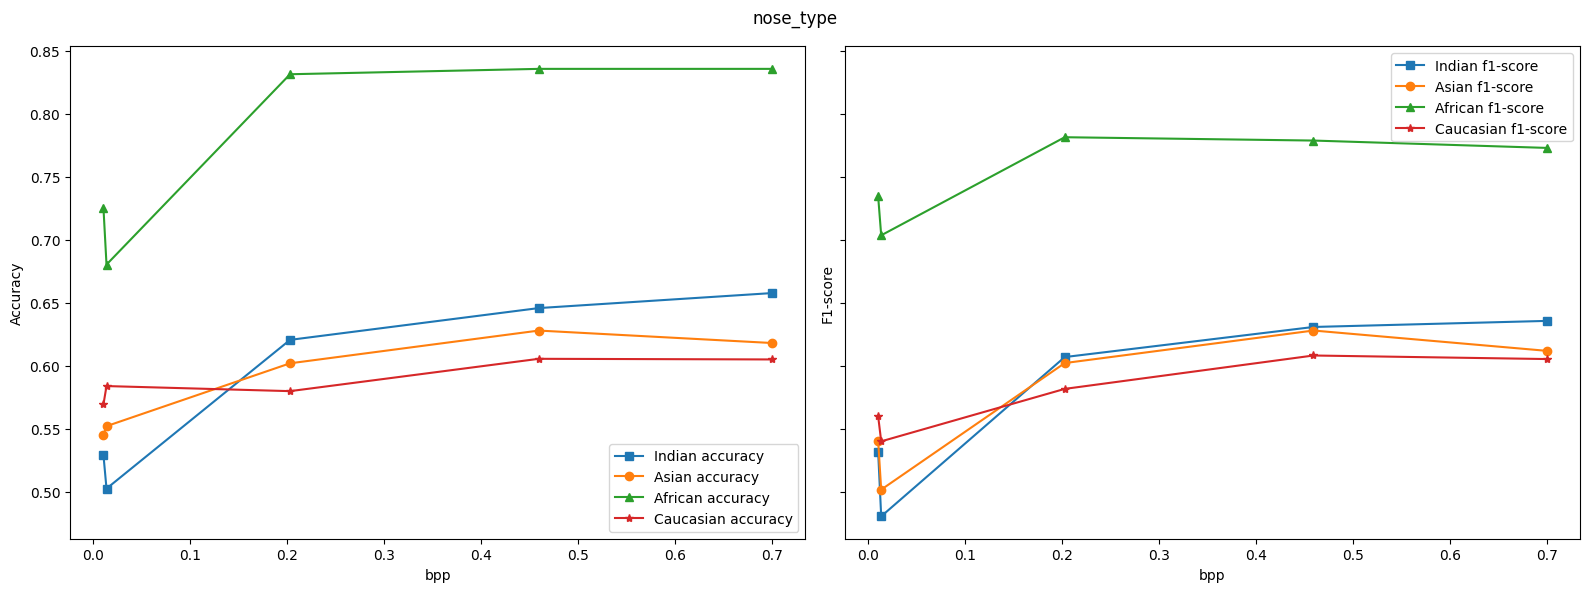

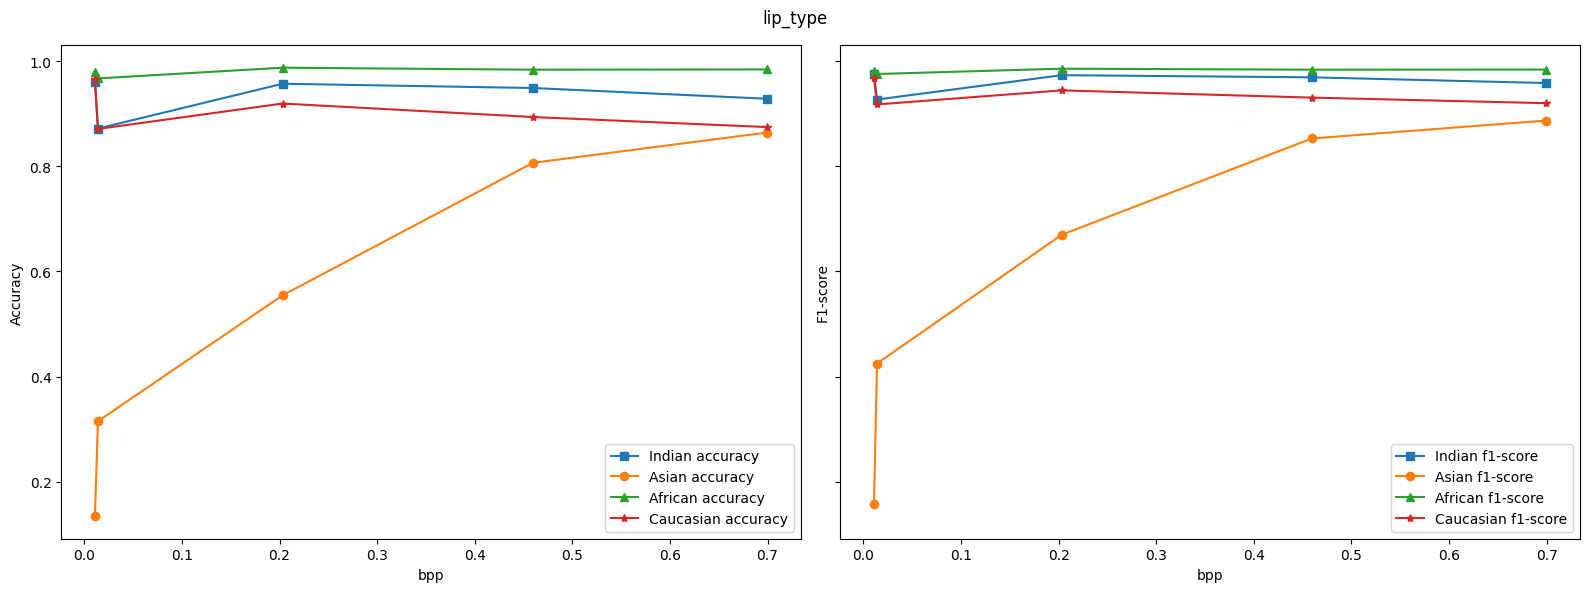

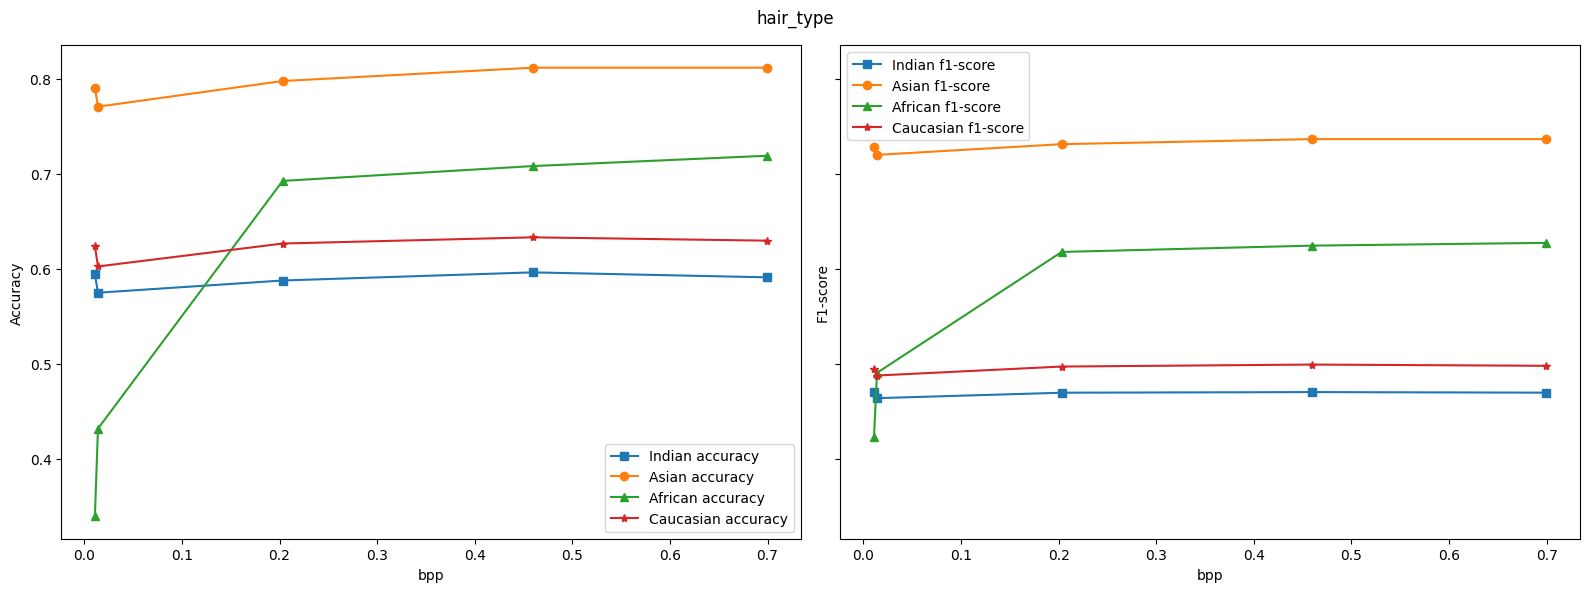

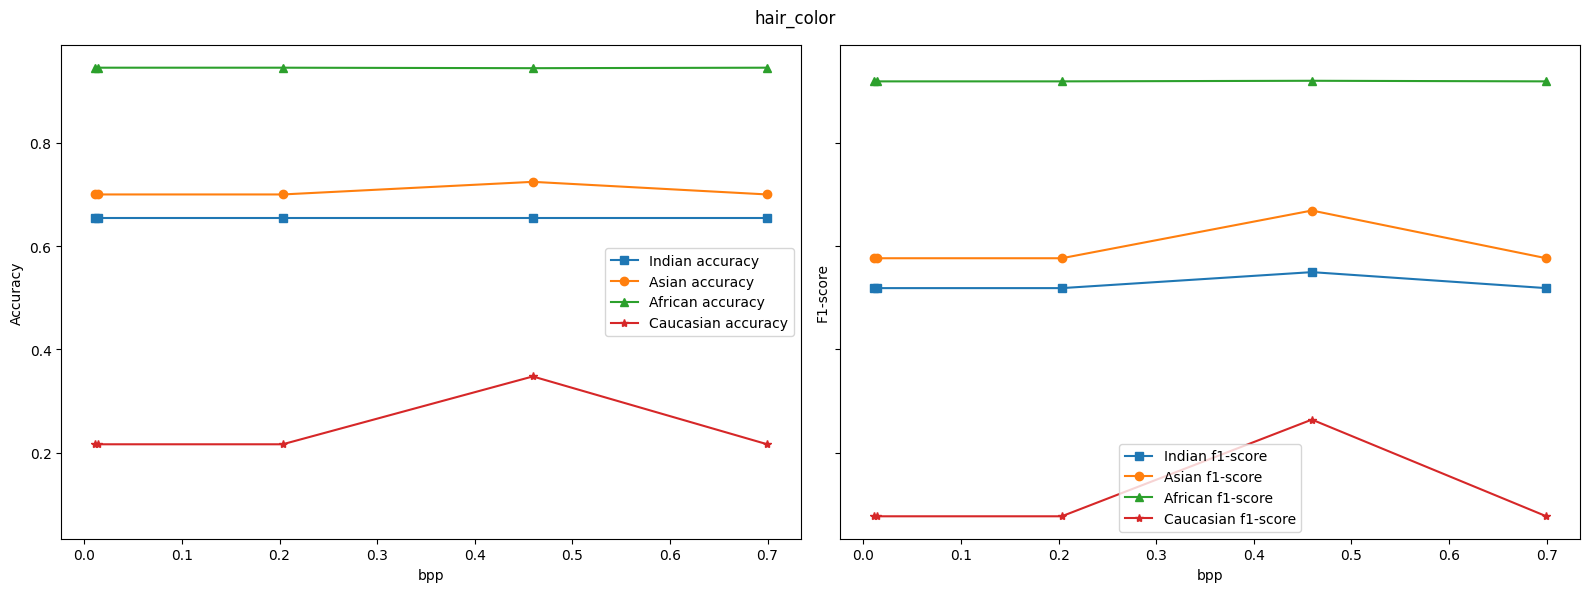

In [29]:
import matplotlib.pyplot as plt
import numpy as np

all_metrics_plot_path = '../results/RFW/plots/output model preds'
race_markers = ['s', 'o', '^', '*']
for i, category in enumerate(categories):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    for j, race in enumerate(races):
        race_accuracies, race_f1_scores = [], []
        for k, data_rate in enumerate(data_rates):
            race_accuracies.append(performance_metrics[k]['acc'][category][race])
            race_f1_scores.append(performance_metrics[k]['f1'][category][race])
    
        axes[0].plot(bpps, race_accuracies, marker=race_markers[j], label=f'{race} accuracy')
        axes[1].plot(bpps, race_f1_scores, marker=race_markers[j], label=f'{race} f1-score')
        axes[1].set_xlabel('bpp')
        axes[0].set_xlabel('bpp')
        axes[0].set_ylabel('Accuracy')
        axes[1].set_ylabel('F1-score')
        axes[0].set_title('')
        
        axes[0].legend()
        axes[1].legend()
    plt.suptitle(category)
    plt.tight_layout()
    plt.savefig(f'{all_metrics_plot_path}/{category}.png')
    plt.show()

# Attribute Distributions Across Races